# Experiments with a Perceptron Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import math


Bad key "hist.bins" on line 40 in
C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "xtick.major.bottom" on line 254 in
C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "xtick.major.top" on line 253 in
C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "ytick.major.left" on line 270 in
C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\styl

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

In [3]:
# Allowing notebooks to reload external python modules
# Details: http://stackoverflow.com/questions/1907993/aut
%load_ext autoreload
%autoreload 2

## Data Preparation
Use pickle to unpack to cifar data

In [4]:

def unpickle(file):
    fo = open(file, 'rb')
    data = pickle.load(fo, encoding = 'bytes')
    return data

Importing the data

In [5]:
file = 'cifar/data_batch_1'
u = unpickle(file)

x = u[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
y = np.array(u[b'labels'])

Visualize the data

In [6]:
classes = {"plane":0,'car':1,'bird':2,'cat':3,'deer':4,'dog':5,'frog':6,'horse':7,'ship':9,'truck':10}
number_of_samples = 7
number_of_classes = len(classes)
class_of_interest = "plane"
idclass = classes[class_of_interest]

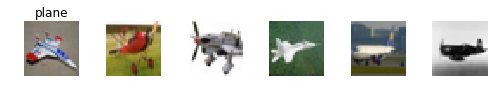

In [7]:
y_sample = np.where(y == idclass)
y_idx = y_sample[0][1:number_of_samples]
offset = 1

for i in y_idx:

    plt.subplot(number_of_samples,number_of_samples,offset)
    plt.imshow(x[i].astype('uint8'))
    if(offset == 1):
        plt.title(class_of_interest)
    offset= offset + 1
    plt.axis('off')

plt.show()

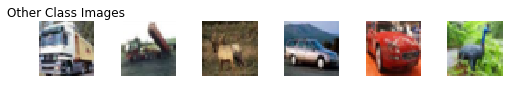

In [8]:
y_otherclass = np.where(y!=idclass)
y_idx = y_otherclass[0][1:number_of_samples]

offset = 1
for i in y_idx:
    plt.subplot(number_of_samples,number_of_samples,offset)
    plt.imshow(x[i].astype('uint8'))
    if(offset == 1):
        plt.title("Other Class Images")
    offset= offset + 1
    plt.axis('off')

plt.show()

In [9]:
x_dataset = x
y_dataset = np.zeros(len(y))
y_dataset[y == idclass] = 1

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(x_dataset, y_dataset, test_size = 0.2)

lets us just confirm the shape of the various arrays and number of inputs

In [12]:
print("# Training Images:", np.shape(xtrain)[0])
print("Dimensions of training image:", np.shape(xtrain)[1:4])
print("# Test Images:", np.shape(xtest)[0])
print("Dimensions of test image:", np.shape(xtest)[1:4])

# Training Images: 8000
Dimensions of training image: (32, 32, 3)
# Test Images: 2000
Dimensions of test image: (32, 32, 3)


We will use vectorized operations here, so let us flatten the matrices

In [13]:
x_train_vector = xtrain.reshape(xtrain.shape[0],-1).T
x_test_vector = xtest.reshape(xtest.shape[0],-1).T

Confirm the shape of the arrays

In [14]:
print("Shape of x train: ", np.shape(x_train_vector))
print("Shape of x test: ", np.shape(x_test_vector))

Shape of x train:  (3072, 8000)
Shape of x test:  (3072, 2000)


Next step is not normalize the data. For normalizing, we subtract the mean from the data and divide the result by the variance.

In [15]:
mean_x = np.mean(x_train_vector)
stddev_x = np.std(x_train_vector)
x_train = (x_train_vector - mean_x) / stddev_x 
x_test = (x_test_vector - mean_x)/stddev_x # Note we subtract the mean of the training from test set 
                                           # and we divide by the stddev of the training set.

Next we will start writing functions that help to implment the logistic regression model

Let us define the numerically stable version of sigmoid function
Note that we can write 
$\frac{1}{1+e^-z}$ as $\frac{e^z}{1+e^z}$

In [16]:
import numpy as np
def sigmoid(x):
    x = np.clip(x, -500,500)
    if x.any()>=0:
        return 1/(1+ np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

### Initialize Parameters

In [33]:
def init_parameters(dim1, dim2=1,std=1e-1, random = True):
    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))

In [93]:
#Single layer network: Forward Prop
def fwd_prop(W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]     
    #print("n_0:",n_0)
    #print("m:",m)
    #print("n_1",n_1)
    
    #Dimensions
    # X = (n_0,m)
    # W1 = (n_1,n_0)
    # B1 = (n_1,1) -> Broadcast -> (n_1,m)
    # Z1 = (n_1,m)
    # A1 = (n_1,m)
    Z1 = np.dot(W1,X) + B1#
    A1 = sigmoid(Z1)
    #print("A1 shape", np.shape(A1))
    return(A1)

In [27]:
#Single layer network: Backprop

def back_prop(A1,W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    
    
    cost = (-1/m)*np.sum(Y*np.log(A1) + (1-Y)*np.log(1-A1))
    #shape(dA1) = shape(A1) = (n_1,m)
    dA1 = Y/A1 + (1-Y)/(1-A1)
    
    #shape(dZ1) = shape(Z1) = (n_1,m)
    dZ1 = A1 - Y
    
    #shape(dW1) = shape(W1) = (n_1,n_0)
    dW1 = (1/m) * np.dot(dZ1, X.T) # dZ1 = (n_1,m), X ->(n_0,m)
    
    #shape(dB1) = shape(B1) = (n_1,1)
    dB1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads ={"dW1": dW1, "dB1":dB1}
    
    return(grads,cost)

In [52]:
def run_grad_desc(num_iterations, learning_rate,X,Y,n_1):
    n_0, m = np.shape(X)
    
    W1 = init_parameters(n_1, n_0, random= False)
    B1 = init_parameters(n_1,1, random = False)
    
    loss_array = np.ones([num_iterations])*np.nan
    for i in np.arange(num_iterations):
        A1 = fwd_prop(W1,B1,X,Y)
        grads,cost = back_prop(A1,W1,B1,X,Y)
        
        W1 = W1 - learning_rate*grads["dW1"]
        B1 = B1 - learning_rate*grads["dB1"]
        
        loss_array[i] = cost
        
        parameter = {"W1":W1,"B1":B1}
    
    return(parameter,loss_array)

In [72]:
np.random.random([10])

array([ 0.95570178,  0.94994095,  0.73638268,  0.05419715,  0.89838582,
        0.29067508,  0.83618053,  0.09421652,  0.20584612,  0.74686618])

In [32]:
w, b, X, Y = np.array([[1, 2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])

a1 = fwd_prop(w,b,X,Y)
grads, cost = back_prop(a1,w, b, X, Y)
print ("dw = " + str(grads["dW1"]))
print ("db = " + str(grads["dB1"]))
print ("cost = " + str(cost))

dw = [[ 0.99993216  1.99980262]]
db = [[ 0.49993523]]
cost = 6.00006477319


In [106]:
X = np.array([[0.25,0.75],[0.1,0.9],[0.3,0.8],[0.8,0.25],[0.9,0.2],[0.7,0.1]])
X = np.array([[0.11,0.12],[0.05,0.1],[0.15,0.11],[0.8,0.9],[0.9,0.8],[0.85,0.95]])
X = X.T
Y = np.array([1,1,1,0,0,0])
params, loss_array = run_grad_desc(100,0.01,X,Y,n_1= 1 )
print(loss_array)
print(params)


[ 0.69314718  0.69242565  0.69170686  0.69099081  0.69027747  0.68956682
  0.68885884  0.68815352  0.68745083  0.68675077  0.6860533   0.68535842
  0.6846661   0.68397633  0.68328909  0.68260436  0.68192213  0.68124237
  0.68056507  0.67989022  0.67921779  0.67854778  0.67788016  0.67721491
  0.67655203  0.67589149  0.67523327  0.67457737  0.67392377  0.67327245
  0.67262339  0.67197659  0.67133201  0.67068966  0.67004951  0.66941155
  0.66877576  0.66814213  0.66751064  0.66688129  0.66625405  0.66562891
  0.66500585  0.66438487  0.66376595  0.66314907  0.66253422  0.66192139
  0.66131056  0.66070172  0.66009485  0.65948995  0.65888699  0.65828598
  0.65768688  0.6570897   0.65649441  0.65590101  0.65530947  0.6547198
  0.65413198  0.65354598  0.65296181  0.65237945  0.65179889  0.65122012
  0.65064311  0.65006787  0.64949438  0.64892263  0.6483526   0.64778429
  0.64721769  0.64665278  0.64608955  0.64552798  0.64496808  0.64440983
  0.64385322  0.64329823  0.64274486  0.64219309  0.

In [103]:
X

array([[ 0.85,  0.95,  0.78,  0.24,  0.11,  0.06],
       [ 0.16,  0.13,  0.21,  0.78,  0.87,  0.91]])

In [96]:
params

{'B1': array([[-0.00022447]]), 'W1': array([[ 0.15806844, -0.1503263 ]])}